# Homework 4 - Recommendation systems and clustering everywhere

## 1. Recommendation sytem

### 1.1 Gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import time
import itertools
from collections import defaultdict 
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
dataset = pd.read_csv("vodclickstream_uk_movies_03.csv")
dataset.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


After reading the data, I will change the data type for the following columns: [datetime and release_date] to a pandas date time object. Also, I will check how many null values are present in my dataset. Lastly, I will replace the name of the column "Unnamed: 0" with "session", as the name makes more sense. 

In [ ]:
dataset.datetime = pd.to_datetime(dataset.datetime)
dataset.release_date = pd.to_datetime(dataset.release_date, errors='coerce')
print(dataset.isnull().sum())
dataset.rename(columns={'Unnamed: 0': 'session'}, inplace=True)

Unnamed: 0          0
datetime            0
duration            0
title               0
genres              0
release_date    30304
movie_id            0
user_id             0
dtype: int64


We have 30304 missing values for release_date column. But for our purpose, this won't be an issue.

Now, we have to gather the **title and genre** of the **top 10** movies, with regards to the **number of clicks** per user. To be able to break down the dataset into a form where I can access the top ten movie titles and genres for each user, I will use `groupby()` and `sort_values()` repetitively on the dataframe.

In [ ]:
user_click_counts = dataset.groupby(['user_id', 'title', 'genres']).size().reset_index(name='click_count')

# Sort the movies for each user based on click counts
user_click_counts = user_click_counts.sort_values(['user_id', 'click_count'], ascending=[True, False])

# Get the top 10 movies for each user
top_10_movies_per_user = user_click_counts.groupby('user_id').head(10)

# Extract title and genre of the top 10 movies
df = top_10_movies_per_user[['user_id', 'title', 'genres', 'click_count']]

In [ ]:
df.head()

,user_id,title,genres,click_count
0,00004e2862,Hannibal,"Crime, Drama, Thriller",1
6,000052a0a0,Looper,"Action, Drama, Sci-Fi, Thriller",9
3,000052a0a0,Frailty,"Crime, Drama, Thriller",3
5,000052a0a0,Jumanji,"Adventure, Comedy, Family, Fantasy",3
7,000052a0a0,Resident Evil,"Action, Horror, Sci-Fi",2


### 1.2

#### Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket.

---

##### Important note: You must write your minhash function from scratch. You are not permitted to use any already implemented hash functions. Read the class materials and, if necessary, conduct an internet search. The description of hash functions in the book may be helpful as a reference.

---
Now, I will define a funtion, name as `get_unique_genres_for_user()`, which will aid in storing **storing** unique genres for each user in the `df` dataframe. I will, again, `groupby()` the `df` dataframe by `user_id` column, select the `genres` column and apply our `get_unique_genres_for_user()` function across the `genres` column. This will output a dataframe, that I have named `user_genres`, which contains two columns: `user_id` and `genres`. `user_id` is a column with, as you will see, unique users and `genres` is a column which has a string of unique genres - concatenated together by commas. 

In [ ]:
def get_unique_genres_for_user(group):
    # Combine all genres for a user into a single list
    all_genres = [genre.split(', ') for genre in group]
    # Flatten the list of lists and create a set of unique genres
    unique_genres = set([item for sublist in all_genres for item in sublist])
    return ', '.join(unique_genres)

In [ ]:
# grouping on user_id, then selection the genres column and applying our function!
user_genres = df.groupby('user_id')['genres'].apply(lambda x: get_unique_genres_for_user(x)).reset_index()
print(user_genres.shape)
user_genres.head(3)

(161918, 2)


,user_id,genres
0,00004e2862,"Crime, Drama, Thriller"
1,000052a0a0,"Action, Comedy, Mystery, Thriller, Horror, Adv..."
2,000090e7c8,"Mystery, Thriller, Sci-Fi"


I will now check to verify if all the values are unique:

In [ ]:
user_genres.user_id.nunique()

161918

Indeed the number of unique user_ids matches the size of the dataframe. Lastly, I will just explore one random entry of the genres column.

In [ ]:
user_genres.genres[1]

'Action, Comedy, Mystery, Thriller, Horror, Adventure, Fantasy, Family, Sci-Fi, Crime, Drama, Sport, Music'

First stop in our Locality Sensitive Hashing process is: **k-Shingling**, or simply **Shingling**. It is the process of converting a string of text into a set of ‘shingles’. The process is similar to moving a window of length k down our string of text and taking a picture at each step. We collate all of those pictures to create our set of shingles. But for our purpose, we will intake the complete word from the genre column.

In [ ]:
# Convert genre string to list ~ Shingle for each user.
user_genres['genres'] = user_genres['genres'].apply(lambda x: x.split(', '))

# Get all unique genres
unique_genres = set()
for genres in user_genres['genres']:
    unique_genres.update(genres)

unique_genres = list(unique_genres)
unique_genres.sort()

# Create a dictionary to map genres to column indices - it will help in one hot encoding later.
genre_to_index = {genre: i for i, genre in enumerate(unique_genres)}

Now, I will build a sparse (one hot encoding matrix), also know as characteristics matrix for our data. Rows are the elements (shingles) and columns will be the User_ids in which they appeared. The entry will be 1 if the element (shingle) is in the column (user_id).

I will follow the procedure of the book.

<img src = "https://drive.google.com/uc?id=1n752VizpcQaPKajZNjjfuQHd9MQy5e0W">

In [ ]:
# Create a matrix representation (one-hot encoding) for users' genres
matrix_representation = [] # matrix initialisation 
for genres in user_genres['genres']: # for each genre_list in user_genres['genres'] column
    # Create a row filled with zeros equal to the number of unique genres
    row = [0] * len(unique_genres)
    for genre in genres: # for each genre in the genres (list)
        # Set the index in the row to 1 for genre index is present in genre_to_index dict
        row[genre_to_index[genre]] = 1
    matrix_representation.append(row)

matrix_df = pd.DataFrame(matrix_representation, columns=unique_genres) # initialisation of empty df
matrix_df.set_index(user_genres['user_id'], inplace=True) # setting index to the user_id column of our original dataframe
matrix_df.index.name = None # to get rid of name when transpose will be applied
matrix_df = matrix_df.T # transposing to get the format, as in the book
print(matrix_df.shape)
matrix_df.iloc[:,:10] # all rows (genres) and first 10 columns.

(27, 161918)


,00004e2862,000052a0a0,000090e7c8,000118a755,000296842d,0002aab109,0002abf14f,0002d1c4b1,000499c2b6,00051f0e1f
Action,0,1,0,0,0,0,0,0,0,1
Adventure,0,1,0,0,0,0,0,0,1,1
Animation,0,0,0,0,0,0,0,0,1,0
Biography,0,0,0,0,0,1,0,0,0,0
Comedy,0,1,0,0,0,1,0,1,1,1
Crime,1,1,0,0,0,1,0,0,0,0
Documentary,0,0,0,0,0,0,0,0,0,0
Drama,1,1,0,0,1,1,1,0,0,0
Family,0,1,0,0,0,0,0,0,1,0
Fantasy,0,1,0,0,0,0,0,0,1,0


Minhashing is the next step in our LSH process, allowing us to convert our sparse vectors into dense vectors. But before we can perform minhashing on our sparse vectors, what we do is generate some carefully chosen hash functions that simulate the effect of permuting the entire rows uniquely. Also, the number of hash functions we chose here would reflect the number of rows we want to create in our dense vector/signature. For example, If we want 8 rows in our signature matrix (dense representation), we would use 8 hash functions. At the end of this, we produce our minhash signature — or dense vector.

Again, I will be following the algorith provided by the author of the book:

---
<img src = "https://drive.google.com/uc?id=1P48autheVmPblZ3k2RrJ97cS_URD0Thu" width="600" height="100">

In [ ]:
# Define the number of: hash functions, unique genres, and hash functions with specific 'a' and 'b' values
num_hash_functions = 8
num_genres = len(unique_genres)
# the values of a and b here are chosen carefully, after much trial and error. they simulate a true permuation.
hash_functions = [(82, 15), (4, 95), (1, 3), (29, 18), (95, 14), (7, 7), (70, 12), (76, 55)]

# Convert the DataFrame to a NumPy array for faster computations
matrix_array = matrix_df.values.astype(int)

# Initialize the signature matrix with infinity values
# of dimension num_hash_functions * num_of_users
signature_matrix = np.full((num_hash_functions, matrix_array.shape[1]), np.inf) 

for r in range(matrix_array.shape[0]):  # Iterate through rows
    for c in range(matrix_array.shape[1]):  # Iterate through columns
        if matrix_array[r, c] != 0: # for all non zero value
            for i, (a, b) in enumerate(hash_functions):  # Iterate through hash functions
                hash_val = ((a * r + b) % num_genres)  # Calculate the hash value
                signature_matrix[i, c] = min(signature_matrix[i, c], hash_val) # take the min and plug it in sig matrix

In [ ]:
signature_df = pd.DataFrame(data=signature_matrix, columns=matrix_df.columns)
signature_df

,00004e2862,000052a0a0,000090e7c8,000118a755,000296842d,0002aab109,0002abf14f,0002d1c4b1,000499c2b6,00051f0e1f,...,fffb9ecb47,fffc1d209b,fffd345213,fffd4d1888,fffd6433d2,fffd9bf758,fffe7b777b,fffeac83be,ffff2c5f9e,ffffd36adf
0,12.0,0.0,3.0,0.0,3.0,18.0,7.0,8.0,16.0,8.0,...,3.0,8.0,16.0,7.0,6.0,3.0,8.0,3.0,3.0,20.0
1,2.0,2.0,2.0,8.0,2.0,3.0,9.0,3.0,3.0,3.0,...,3.0,3.0,3.0,2.0,5.0,7.0,2.0,3.0,2.0,7.0
2,0.0,0.0,0.0,15.0,0.0,6.0,10.0,7.0,4.0,3.0,...,6.0,2.0,4.0,0.0,21.0,8.0,0.0,1.0,0.0,8.0
3,1.0,1.0,4.0,15.0,4.0,1.0,2.0,4.0,7.0,4.0,...,1.0,1.0,7.0,2.0,0.0,1.0,4.0,1.0,3.0,1.0
4,3.0,1.0,8.0,20.0,4.0,2.0,4.0,16.0,1.0,1.0,...,2.0,0.0,1.0,4.0,23.0,3.0,4.0,2.0,8.0,3.0
5,2.0,2.0,4.0,10.0,2.0,1.0,2.0,8.0,8.0,7.0,...,1.0,0.0,8.0,2.0,25.0,4.0,2.0,1.0,4.0,2.0
6,11.0,1.0,8.0,15.0,8.0,6.0,16.0,8.0,1.0,1.0,...,0.0,1.0,1.0,12.0,3.0,0.0,8.0,0.0,0.0,11.0
7,3.0,1.0,7.0,2.0,7.0,3.0,14.0,8.0,8.0,1.0,...,3.0,1.0,8.0,1.0,19.0,3.0,9.0,0.0,1.0,3.0


As can be analysed from the result, we have reduced the dimension of the rows from **27*161918** to **8*161918**. But one might ask, why even minhash? Would the similarity perspective be preserved?

Surpirsingly, **YES**. There is a remarkable connection between minhashing and Jaccard similarity of the sets that are minhashed. The probability that the minhash function for a random permutation of rows produces the same value for two sets equals the Jaccard similarity of those sets.

---

The main idea behind LSH is to efficiently group similar items by hashing them multiple times to the same bucket, aiming to minimize dissimilar items ending up in the same bucket. By considering pairs that hash to the same bucket across various hashings as candidates for similarity comparison, LSH reduces computational load. 

The goal is to optimize true similar pairs hashing to the same bucket while limiting false positives. When using minhash signatures, LSH divides the signature matrix into **bands**. Each **band applies a hash function to vectors of integers, directing them to numerous buckets**. In other words, we want to maximize collisions — although ideally only for similar inputs.

The number of bands must follow this equation: n = b x r. Here, n is the total number of rows, which in our case is 8, b is the number of bands one would like to use, and r would be the number of rows within each band. Let's deploy this concept.

In [ ]:
from collections import defaultdict
#4 bands, 2 rows = 8 rows (total)
num_bands = 4  # Define the number of bands
rows_per_band = signature_matrix.shape[0] // num_bands  # Define the number of rows per band
n_users = signature_matrix.shape[1]  # Number of users/customers

# Initialize a dictionary to store buckets
buckets = defaultdict(list)

# Define a Hashing function based on our minhash value
def minhash_based_hashing(signature_values):
    # Convert the signature values to a string for hashing
    signature_sum = sum(signature_values)
    return ((23*signature_sum + 89) % 997) # return the string HASHED


# Perform LSH by hashing users into buckets
for idx_user, column in enumerate(signature_matrix.T):  # Iterate over columns (users)
    for idx_band, band in enumerate(np.split(column, num_bands)):  # Split into bands
        # Create keys for the buckets using a tuple of band index and band values
        bucket_key = minhash_based_hashing(band.tolist())
        buckets[bucket_key].append(idx_user)  # Append the user index to the corresponding bucket

In [ ]:
len(buckets) # we have 354 distinct buckets!!!

# our bucket is a dict defined in a way that the key is the value of the hash function and value is the list 
# of user_ids that go (hash into) these buckets

46

### 1.3 Locality-Sensitive Hashing (LSH)

Now that your buckets are ready, it's time to ask a few queries. We will provide you with some user_ids and ask you to recommend at most five movies to the user to watch based on the movies clicked by similar users.

To recommend at most five movies given a user_id, use the following procedure:

1. Identify the two most similar users to this user.
2. If these two users have any movies in common, recommend those movies based on the total number of clicks by these users.
3. If there are no more common movies, try to propose the most clicked movies by the most similar user first, followed by the other user.

**Example:** assume you've identified user **A** and **B** as the most similar users to a single user, and we have the following records on these users:

- User A with 80% similarity
- User B with 50% similarity

| user | movie title | #clicks |
|----------|----------|----------|
| A | Wild Child | 20 |
| A | Innocence | 10 |
| A | Coin Heist | 2 |
| B | Innocence | 30 |
| B | Coin Heist | 15 |
| B | Before I Fall | 30 |
| B | Beyond Skyline | 8 |
| B | The Amazing Spider-Man | 5 |

**Recommended movies** in order:
- Innocence
- Coin Heist
- Wild Child
- Before I Fall
- Beyond Skyline

---

In [ ]:
random_col = random.randint(1, signature_df.shape[1]) # a random column number
query = signature_df.iloc[:,random_col].name # to get the name of the col (user_id)
user_id_index = signature_df.columns.get_loc(query) # get the index of the user_id col
user_id_index

1901

In [ ]:
def jaccard_similarity(set1, set2):
    # Calculate Jaccard similarity between two sets
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def find_two_most_similar_users(user_id, buckets):
    # Find the bucket containing the given user
    user_buckets = set() # I assume there is a chance that a user is present in more than one bucket, tho it is rare.
    for bucket_key, users in buckets.items():
        if user_id in users: # if our user (the query) is in the list
            user_buckets.update(users) # update the user_buckets with the list of similar users
        
    if not user_buckets:
        return None  # User not found in any bucket

    # Calculate similarity of the given user with users in the bucket
    similarities = {}
# calculate the jaccard_similarity between query and every other user in our bucket/list of similar users
    for other_user_id in user_buckets:
        if other_user_id != user_id:
            user_set = set(signature_matrix[:, user_id])
            other_user_set = set(signature_matrix[:, other_user_id])
            similarities[other_user_id] = jaccard_similarity(user_set, other_user_set)

    # Find the two most similar users
    most_similar_users = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:2]
    return most_similar_users


In [ ]:
most_similar_users = find_two_most_similar_users(user_id_index, buckets)
print(most_similar_users)

[(131144, 1.0), (131333, 1.0)]


How to interpret the result? the first value in the tuple is the user_id and the second value is the jaccard similarity

In [ ]:
list_of_users = [user for user, _ in most_similar_users]
list_of_scores = [score for _, score in most_similar_users]
user_ids = list()
for user in list_of_users:
    user_ids.append(signature_df.iloc[:,user].name)
user_ids # this will help in making the movies dataframe of these users

['cf644231f2', 'cfb34b3a77']

In [ ]:
movies = df[df["user_id"].isin(user_ids)].reset_index(drop=True)
movies

,user_id,title,genres,click_count
0,cf644231f2,The Ballad of Buster Scruggs,"Comedy, Drama, Musical, Mystery, Romance, Western",1
1,cfb34b3a77,The Ballad of Buster Scruggs,"Comedy, Drama, Musical, Mystery, Romance, Western",1


If these two users have any movies in common, recommend those movies based on the total number of clicks by these users.

In [ ]:
two_similar_users = list()
for x,y in zip(user_ids, list_of_scores):
    two_similar_users.append((x,y))
two_similar_users # simialr to most_similar_users, but with the original user_id and not the col_index

[('cf644231f2', 1.0), ('cfb34b3a77', 1.0)]

In [ ]:
def recommend_movies(movies, two_similar_users):
    """
    Given data of movies, I have to do the following:
    initialise a list called: results
    First, check if there are some common titles between two users:
    for each common title, count the number of clicks by each user and sum it. then, sort the common titles by the sum of the number of clicks by each user and append the name of the title into the list: results.
    Then, If there are no more common movies, try to propose the most clicked movies by the most similar user first, followed by the other user. add those result after the results already in the list: results.
    then print the first 5 results of the list: result
    """
    # Find common movies
    user_ids = [user[0] for user in two_similar_users]
    common_movies = set(movies[movies['user_id'] == user_ids[0]]['title']).intersection(
        set(movies[movies['user_id'] == user_ids[1]]['title'])
    )

    # Initialize a set called 'results' to avoid duplicates
    results = list()
    common_movies_df = pd.DataFrame
    if common_movies:
        # If there are common movies, recommend those based on the total number of clicks by these users
        common_movies_df = movies[movies['title'].isin(common_movies)].groupby('title')['click_count'].sum().reset_index()
        common_movies_df = common_movies_df.sort_values(by='click_count', ascending=False)
        results.extend(common_movies_df['title'].tolist())

    # Propose the most clicked movies by each user
    if not common_movies_df.empty:
        movies = movies[~movies["title"].isin(common_movies_df['title'].tolist())]
    for user_id, _ in two_similar_users: # first user_id is automatically with the largest similarity score
        user_movies = movies[movies['user_id'] == user_id].groupby('title')['click_count'].sum().reset_index()
        user_movies = user_movies.sort_values(by='click_count', ascending=False)
        results.extend(user_movies['title'].tolist())

    # Return the recommended movie titles
    return list(results)[:5]  # Return the first 5 unique results

In [ ]:
recommend_movies(movies, two_similar_users)

['The Ballad of Buster Scruggs']

Credits: `https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing/`and Mining of Massive Datasets Book.

## 2.

### 2.1 Getting your data + feature engineering

#### 2.1.1 Access to the data

In [ ]:
# Libraries that we need
import pandas as pd
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # to normalize the data
from sklearn.decomposition import PCA                                                                                                        

Let's import and see what the dataframe we need to work on looks like. 
There are 671736 rows × 8 columns, with *data.info()* we can figure out what they are and what types of data they contain.
We realize that both the _"datetime"_ column and the _"release_date"_ column should be of type datetime, so we proceed to convert them.

In [ ]:
data = pd.read_csv("vodclickstream_uk_movies_03.csv")
data.datetime = pd.to_datetime(data.datetime)
data.release_date = pd.to_datetime(data.release_date, errors='coerce')

In [ ]:
data.isna().sum() # only release_data has 30304 na values and they were the "NOT AVAILABLE", also genres has 26561 "NOT AVAILABLE" rows but we are not going to remove them because we do not want to loose data

Unnamed: 0          0
datetime            0
duration            0
title               0
genres              0
release_date    30304
movie_id            0
user_id             0
dtype: int64

In [ ]:
to_drop = data[data["duration"] < 0].index # 21734 
# We can see that there are 21734 where duration is -1, we can drop them or convert this to 0 but 0 here has a different meaning so it's better to drop them
data = data.drop(to_drop).reset_index()

<Axes: title={'center': 'Duration distribution'}, ylabel='Frequency'>

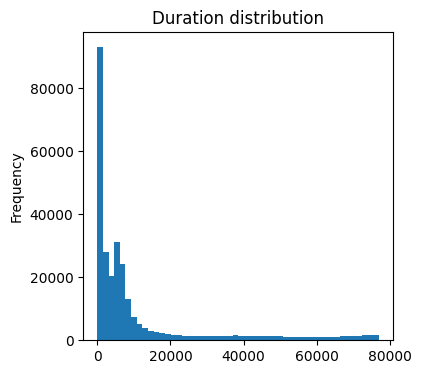

In [ ]:
# Our only numeric variable is duration, let"s see how it is distributed
data.duration.describe() # We can see that the duration assumes values from 0 to 1.823725e+07 but the median is 43 and the 3rd quartile is 7059
# the duration is very often 0, but we can do an histogram exluding 0 and to big numbers to see how the other values are
data[(data["duration"] <= np.quantile(data["duration"],0.9)) & (data["duration"] > 0)].duration.plot(kind="hist",bins=50, figsize=(4,4), title = "Duration distribution") # we have lot of small numbers

#### 2.1.2 feature engeneering of the 5 mandatory variables

##### 1st feature, favorite genre
Here we have to create a new column for the genre the user spends most time.

In [ ]:
# how many different genres we have? Let's count them
data.genres.apply(lambda row: row.split(","))
data["genres_list"] = ""
data["genres_list"] = data.genres.apply(lambda row: [word.strip() for word in row.split(",")])
data["genres_list"]
unique_genres = set()
data["genres_list"].apply(lambda row: [unique_genres.add(value) for value in row])
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'NOT AVAILABLE',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [ ]:
# Now we can create our new first feature
# First we need to divide the column with the list of the genres in rows cointaining only one genre
df_genres = data["genres_list"].apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame("genre")
# Merging with the original data
data2 = pd.merge(data, df_genres, left_index=True, right_index=True)
# Grouping in only the user_id and the genre column and this column contains only one genre.
grouped_df = data2.groupby(["user_id", "genre"])
# From the grouped_df we need to calculates the durations for each user for each genre he saw
genre_duration = grouped_df["duration"].sum().reset_index()
# Searching for the indexes with the max duration grouping by user_id so every user will have only one genre
idx = genre_duration.groupby("user_id")["duration"].idxmax()

# Creating a new dataframe where we put this new column 
user_df = genre_duration.loc[idx, ["user_id", "genre"]]

##### 2nd feature, average click duration

In [ ]:
average_click_duration = pd.DataFrame(data.groupby("user_id").duration.mean())
user_df = user_df.merge(average_click_duration, how = "outer", on = "user_id")
user_df = user_df.rename(columns={"duration": "average_click_duration"})

##### 3rd feature, time of the day

In [ ]:
def map_time_period(value):
    if 6 <= value < 14:
        return "Morning"
    elif 14 <= value < 22:
        return "Afternoon"
    else:
        return "Night"

##### 4th feature, old movie lover

In [ ]:
data["hour_of_day"] = 0
data["hour_of_day"] = data.datetime.dt.hour
df = data.groupby(by=['user_id','hour_of_day']).duration.mean().reset_index()
df_first = df.sort_values(["user_id","hour_of_day"], ascending=[True, False]).groupby('user_id', as_index=False).first()

# Now that we have the hour we need to change it in "morning","afternoon" and "night"
df_first["hour_of_day_categorial"] = df_first["hour_of_day"]
df_first["hour_of_day_categorial"] = df_first["hour_of_day_categorial"].apply(map_time_period)

# Now we merge the categorial variable in the dataframe with the new features
user_df = user_df.merge(df_first[["user_id","hour_of_day_categorial"]], how="outer", on="user_id")

In [ ]:
data['oldmovie'] = False
data['oldmovie'] = data.release_date.dt.year < 2010
# Counting how many oldmovie and how many newmovie the user saw
df2 = data.groupby(['user_id', 'oldmovie'])['movie_id'].count().reset_index()
# Ordering and selecting the first row for every user so the the ones with the highest count
df_oldnew = df2.sort_values(['user_id', 'oldmovie']).groupby('user_id', as_index=False).first()
# Merging again
user_df = user_df.merge(df_oldnew[["user_id","oldmovie"]], how="outer", on="user_id")

##### 5th feature, average time spent a day by the user

In [ ]:
# We convert the datetime column to a column containing only the day and not also the time, we need it to create the denominator to calculate our new feature
data["date"] = data["datetime"].dt.date
# Here we create a dataframe such that it contains the sum of the total duration for each user
sum_df = data.groupby(["user_id"])["duration"].sum().reset_index()
# Here we count the days each user logged in
days_logged_in = data.groupby("user_id")["date"].nunique().reset_index()
# In "grouped_df" we merge the 2 dataframe created always on the user_id
grouped_df = pd.merge(sum_df, days_logged_in, on="user_id", suffixes=("", "_total_days"))
# Let's calculate our new feature
grouped_df["average_duration_per_day"] = grouped_df["duration"] / grouped_df["date"]
# Merging the new feature to the new dataset for the users
user_df = user_df.merge(grouped_df[["user_id","average_duration_per_day"]], how = "outer", on="user_id")

#### 2.1.3 feature engeneering of 10 other variables

##### 1st free feature: total number of acces per User, column name "days_logged_in"
Thise features counts the total number of accesses for each user. We alreary have this feature because we used it in the computation of the mandotary column number 5, the average time spent a day by the user so we just have to merge the feature to our new dataframe.

In [ ]:
user_df = user_df.merge(days_logged_in, how="outer", on="user_id")
user_df = user_df.rename(columns={"date": "days_logged_in"})

##### 2nd free feature: First access date of the user, column name "first access"

In [ ]:
first_access = data.groupby(["user_id"])["date"].min()
user_df = user_df.merge(first_access, how="outer", on="user_id")
user_df = user_df.rename(columns={"date": "firts_access"})

##### 3rd free feature: Total duration on old movies, column name "old_movie_duration"

In [ ]:
filtered_data = data[data["oldmovie"] == True]
# Calcola la media della durata raggruppando per user_id e oldmovie
movie_duration = pd.DataFrame(filtered_data.groupby(["user_id", "oldmovie"])["duration"].mean().reset_index())
user_df = user_df.merge(movie_duration[["user_id","duration"]], on="user_id", how="left")
user_df = user_df.rename(columns={"duration": "old_movie_duration"})
user_df["old_movie_duration"] = user_df["old_movie_duration"].fillna(0)

##### 4th free feature: Total duration on new movies, column name "new_movie_duration"

In [ ]:
filtered_data = data[data["oldmovie"] == False]
# Calcola la media della durata raggruppando per user_id e oldmovie
movie_duration = pd.DataFrame(filtered_data.groupby(["user_id", "oldmovie"])["duration"].mean().reset_index())
user_df = user_df.merge(movie_duration[["user_id","duration"]], on="user_id", how="left")
user_df = user_df.rename(columns={"duration": "new_movie_duration"})
user_df["new_movie_duration"] = user_df["new_movie_duration"].fillna(0)

##### 5th free feature : most active day of the week, column name "active_day"

In [ ]:
# Estrai il giorno della settimana dalla colonna 'datetime'
data['day_of_week'] = data['datetime'].dt.day_name()

# Raggruppa per 'user_id' e 'day_of_week', contando il numero di accessi
user_most_active_day = data.groupby(['user_id', 'day_of_week'])['day_of_week'].count().reset_index(name='count')

# Trova l'indice del massimo per ciascun utente
idx = user_most_active_day.groupby('user_id')['count'].idxmax()

# Seleziona le righe corrispondenti agli indici del massimo
most_active_day_per_user = user_most_active_day.loc[idx, ['user_id', 'day_of_week', 'count']]
user_df = user_df.merge(most_active_day_per_user[["user_id","day_of_week"]], how = "outer", on = "user_id")
user_df = user_df.rename(columns={"day_of_week": "active_day"})

##### 6th free feature : Number of genres cliked, column name = "genres_clicked"

In [ ]:
number_of_genres_clicked = data2.groupby('user_id')['genres'].nunique().reset_index(name='genres_clicked')
user_df = user_df.merge(number_of_genres_clicked, how = "outer", on = "user_id")

##### 7th free feature : Longest consecutive active days, column name "longest_consecutive_days"

In [ ]:
data = data.sort_values(by=['user_id', 'datetime'])
data['date_diff'] = data.groupby('user_id')['datetime'].diff().dt.days.fillna(0)
consecutive_days_mask = (data['date_diff'] == 1)
data['consecutive_days_count'] = consecutive_days_mask.groupby(data['user_id']).cumsum()
longest_sequence = data.groupby('user_id')['consecutive_days_count'].max().reset_index(name='longest_consecutive_days')
user_df = user_df.merge(longest_sequence, how = "outer", on = "user_id")

##### 8th free feature : Last access date, column name "last_access"

In [ ]:
last_access = data.groupby(["user_id"])["date"].max()
user_df = user_df.merge(last_access, how="outer", on="user_id")
user_df = user_df.rename(columns={"date": "last_access"})

##### 9th free feature : Average click duration on weekdays

In [ ]:
data['is_weekend'] = data['datetime'].dt.weekday >= 4
filtered_data_day = data[data["is_weekend"] == False]
movie_duration_weekdays = pd.DataFrame(filtered_data_day.groupby(["user_id", "is_weekend"])["duration"].mean().reset_index(name="duration_weekdays"))
user_df = user_df.merge(movie_duration_weekdays[["user_id","duration_weekdays"]], on="user_id", how="left").fillna(0)

##### 10th free feature: Average click duration on weekends

In [ ]:
filtered_data_day_2 = data[data["is_weekend"] == True]
movie_duration_weekend = pd.DataFrame(filtered_data_day_2.groupby(["user_id", "is_weekend"])["duration"].mean().reset_index(name="duration_weekends"))
user_df = user_df.merge(movie_duration_weekend[["user_id","duration_weekends"]], on="user_id", how="left").fillna(0)

Let's now see the final dataframe user_df

In [ ]:
user_df.head(5)

,user_id,genre,average_click_duration,hour_of_day_categorial,oldmovie,average_duration_per_day,days_logged_in,firts_access,old_movie_duration,new_movie_duration,active_day,genres_clicked,longest_consecutive_days,last_access,duration_weekdays,duration_weekends
0,00004e2862,Crime,0.000000,Afternoon,True,0.0,1,2017-12-05,0.000000,0.0,Tuesday,1,0,2017-12-05,0.0,0.000000
1,000052a0a0,Action,2024.166667,Night,False,4858.0,10,2017-05-23,1732.111111,2199.4,Sunday,11,1,2017-06-26,2197.5,1900.357143
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.0,1,2018-03-09,0.000000,0.0,Friday,1,0,2018-03-09,0.0,0.000000
3,000118a755,Horror,0.000000,Night,False,0.0,2,2018-06-14,0.000000,0.0,Friday,2,0,2018-06-15,0.0,0.000000
4,000296842d,Drama,11044.000000,Night,False,38654.0,2,2018-12-30,0.000000,11044.0,Monday,1,0,2018-12-31,12873.4,6470.500000


In [ ]:
# we can also save this new dataframe to not always run everything
user_df.to_csv("user.csv", index=False)

### 2.2 Choose your features (variables)!

#### 2.2.1 Normalization

Many learning algorithms assume that all featured are centered around zero and have a variance of the same order.
So, we want to normalise our varibales.
Of course, not all variables need to be normalised.
For example, we will not normalise date-columns or categorial variables. 
But we need to pay attention at the variances of real-valued variables, because they can confound our analysis

In [ ]:
user_df = pd.read_csv("user.csv")

In [ ]:
# We need to fisrt check our data because we do not want infinite values or any other errors, it seems that our data is ok so we can go on
# Coping the dataframe created for the users
user_df_normalized = user_df.copy()
to_norm = user_df_normalized.select_dtypes(include=["int64","float64"]).keys()
variables = user_df_normalized[to_norm]
scaler = StandardScaler().fit(variables.values)
variables = scaler.transform(variables.values)
user_df_normalized[to_norm] = variables
user_df_normalized.describe()
# All the means are equal to 0 (they are very low) and the standard deviation is 1 (almost 1)

,average_click_duration,average_duration_per_day,days_logged_in,old_movie_duration,new_movie_duration,genres_clicked,longest_consecutive_days,duration_weekdays,duration_weekends
count,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05,1.543880e+05
mean,-2.798210e-17,6.751601e-17,1.145517e-16,-1.426719e-17,2.924773e-17,5.154597e-18,5.396218e-18,-2.262040e-17,9.618845e-18
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.712040e-01,-2.977969e-01,-5.442600e-01,-1.492598e-01,-2.463530e-01,-5.481465e-01,-3.743935e-01,-2.183727e-01,-2.181328e-01
25%,-2.712040e-01,-2.977969e-01,-5.442600e-01,-1.492598e-01,-2.463530e-01,-5.481465e-01,-3.743935e-01,-2.183727e-01,-2.181328e-01
50%,-2.513756e-01,-2.713028e-01,-1.927199e-01,-1.492598e-01,-2.376377e-01,-2.517403e-01,-3.743935e-01,-2.183727e-01,-2.181328e-01
75%,-1.132558e-01,-9.221127e-02,1.588201e-01,-1.483778e-01,-1.302131e-01,4.466598e-02,-3.743935e-01,-1.589080e-01,-1.632953e-01
max,6.600016e+01,6.842756e+01,3.074280e+01,1.508879e+02,7.000681e+01,2.879607e+01,3.236261e+01,7.768819e+01,6.377235e+01


In [ ]:
user_df_normalized.head(5)

,user_id,genre,average_click_duration,hour_of_day_categorial,oldmovie,average_duration_per_day,days_logged_in,firts_access,old_movie_duration,new_movie_duration,active_day,genres_clicked,longest_consecutive_days,last_access,duration_weekdays,duration_weekends
0,00004e2862,Crime,-0.271204,Afternoon,True,-0.297797,-0.54426,2017-12-05,-0.149260,-0.246353,Tuesday,-0.548147,-0.374394,2017-12-05,-0.218373,-0.218133
1,000052a0a0,Action,-0.259511,Night,False,-0.273962,2.61960,2017-05-23,-0.134915,-0.232884,Sunday,2.415916,0.794785,2017-06-26,-0.203449,-0.204779
2,000090e7c8,Mystery,-0.271204,Afternoon,False,-0.297797,-0.54426,2018-03-09,-0.149260,-0.246353,Friday,-0.548147,-0.374394,2018-03-09,-0.218373,-0.218133
3,000118a755,Horror,-0.271204,Night,False,-0.297797,-0.19272,2018-06-14,-0.149260,-0.246353,Friday,-0.251740,-0.374394,2018-06-15,-0.218373,-0.218133
4,000296842d,Drama,-0.207405,Night,False,-0.108148,-0.19272,2018-12-30,-0.149260,-0.178720,Monday,-0.548147,-0.374394,2018-12-31,-0.130949,-0.172663


#### 2.2.2 PCA

First, notice we have both numerical and categorical variables.
But on closer analysis, we find that categorical variables are often obtained from numerical ones. Think for example of "hour_of_day" or "active_day" they are directly obtained from "Duration"!
We can then think of focusing our attention exclusively on numerical variables, and this allows us to be able to perform dimensionality reduction with PCA (which does not support qualitative variables).

In [ ]:
X = user_df_normalized.copy() # we create a copy of the dataset
# We drop non-numerical columns:
numeric_cols = X.select_dtypes(include = 'number' ).columns.tolist()
X = X[numeric_cols]
X

,average_click_duration,average_duration_per_day,days_logged_in,old_movie_duration,new_movie_duration,genres_clicked,longest_consecutive_days,duration_weekdays,duration_weekends
0,-0.271204,-0.297797,-0.54426,-0.149260,-0.246353,-0.548147,-0.374394,-0.218373,-0.218133
1,-0.259511,-0.273962,2.61960,-0.134915,-0.232884,2.415916,0.794785,-0.203449,-0.204779
2,-0.271204,-0.297797,-0.54426,-0.149260,-0.246353,-0.548147,-0.374394,-0.218373,-0.218133
3,-0.271204,-0.297797,-0.19272,-0.149260,-0.246353,-0.251740,-0.374394,-0.218373,-0.218133
4,-0.207405,-0.108148,-0.19272,-0.149260,-0.178720,-0.548147,-0.374394,-0.130949,-0.172663
...,...,...,...,...,...,...,...,...,...
154383,-0.222130,-0.256118,-0.54426,-0.149260,-0.194330,-0.548147,-0.374394,-0.160683,-0.218133
154384,-0.260892,-0.289039,-0.54426,-0.149260,-0.235422,-0.548147,-0.374394,-0.218373,-0.205589
154385,-0.036629,-0.023859,1.91652,0.773647,-0.094076,1.823104,0.794785,0.155062,-0.202307
154386,-0.271204,-0.297797,-0.54426,-0.149260,-0.246353,-0.251740,-0.374394,-0.218373,-0.218133


Let's see what Principal Component Analysis is and why it is usefull for us.   
In principal component analysis, we start with the data matrix $X$ that consists of $NxD$ variables and obtain a matrix with $N$ rows but the columns are a smaller number.                              
Principal components are summaries of the information (variance) that is contained in the original variables.                  
The main purpose for which it is used in data analysis is for **dimensionality reduction**. 


You get to have a number of principal components that are _uncorrelated_ with each other and each of the components summarizes a part of the _variance_; the first component summarizes as much variance as possible and the other components will summarize a smaller amount of variance.                     
Principal components are not observable, they represent latent concepts i.e., a summary of variables that are observable and are correlated with each other.


**Geometrically**, the PCA produces an _orthogonal projection_ of the datapoints "cloud" representing the $n$ statistical units in the $D$-dimensional space of variables into a subspace of lower dimensions.                          
The objective of this projection that is made by the PCA is to distort the point cloud as little as possible by minimizing the sum of the squares of the differences between the Euclidean distances between pairs of points and their projections in the reduced space.                                   
The first component is placed where the range of variation of the datapoints is largest, and the second component is orthogonal to the first and is placed where there is most variance that has not yet been explained.

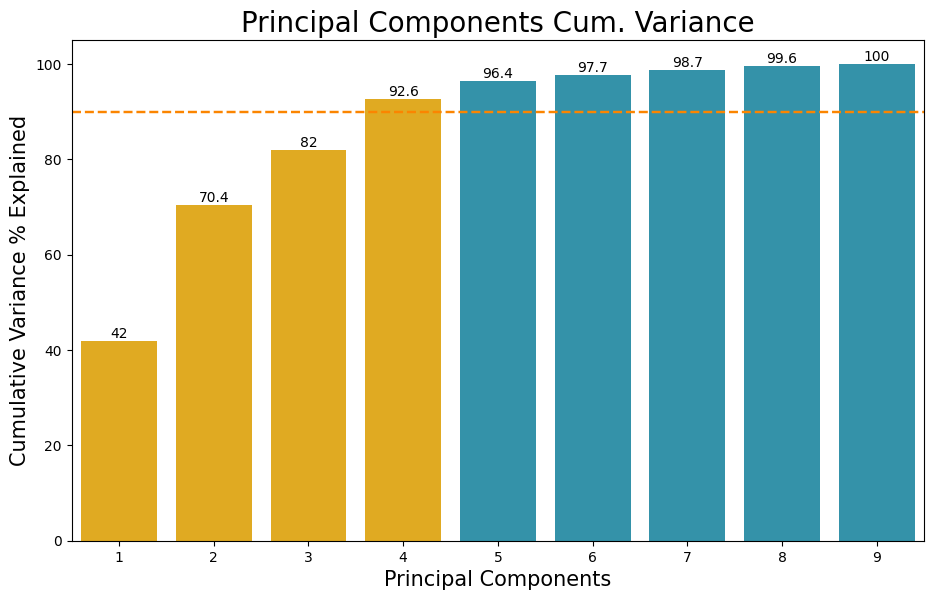

**************************************************************************************************************

Our 4 principal components:


array([[-5.42706645e-01, -8.76951238e-01, -9.53061426e-03,
         5.05860885e-03],
       [-6.94620576e-01,  3.37693692e+00, -9.87110152e-02,
        -8.44614763e-02],
       [-5.42706645e-01, -8.76951238e-01, -9.53061426e-03,
         5.05860883e-03],
       ...,
       [-4.36479467e-02,  2.67104995e+00,  3.24277595e-01,
         6.22613931e-01],
       [-5.51412151e-01, -7.06649958e-01, -1.27360779e-02,
         1.49891256e-03],
       [-5.42706645e-01, -8.76951238e-01, -9.53061426e-03,
         5.05860885e-03]])

In [ ]:
# Now that we have our new dataset ready, we search the optimal number of principal components:

def pca_hw4(X, treshold):
    
    # Part 1: We find the optimal number of components ------------------------------------
    n = len(X.axes[1]) # number of columns of X
    covar_matrix = PCA(n_components = n).fit(X) 
  
    ## Variance explained for each of the principal components
    variance = covar_matrix.explained_variance_ratio_
    cumulative_var = np.cumsum( np.round(variance, decimals = 3) * 100 )

    ## Find the number of components you need to go over your treshold:
    num_components = len(cumulative_var) # default value
    for i in range(len(cumulative_var)):
        if cumulative_var[i] >= treshold:
            num_components = i+1
            break     

    # Part 2: Plot to find the number of principal components you need ---------------------

    tot_num_components = len(cumulative_var)
    
    x = [x for x in range(1, tot_num_components + 1)] # numbers from 1 to maximum number of components
    y = [var for var in cumulative_var] # value of the cumulative variance

    # We will color the component that reaches to explain the desired level of variance with a different color
    customized_col = ["#FFB703" if c <= num_components else "#219EBC" for c in x] 

    fig, ax = plt.subplots(figsize=(11, 6.5))

    ax.set_title('Principal Components Cum. Variance', fontsize = 20)
    ax.set_ylabel('Cumulative Variance % Explained', fontsize = 15)
    ax.set_xlabel('Principal Components', fontsize = 15)

    ax.axhline(treshold, color = '#FB8500', linewidth = 1.75, linestyle = "--")

    sns.barplot(x = x,y = y, palette = customized_col) 
    ax.bar_label(ax.containers[0])
    plt.show()

    # Part 3: we perform the PCA with the chosen number of principal components ------------------

    pca = PCA(n_components = num_components)
    principal_components = pca.fit_transform(X)

    # Part 4: Just the print of the dataframe containing the principal components -------------------

    print('*' * 110) # only to divide the output...
    print('')
    print('Our', num_components, 'principal components:')

    return principal_components
    

pca_analysis = pca_hw4(X, treshold = 90)
pca_analysis

As we can see with only 3 principal components we can summarize 82% of the total variance, with 4 components we would have 92.6%                     
We can also try to see the combination of variables that created each principal component with an heatmap.                
_pca.components_**2_ Square the elements of the principal component matrix. This represents the percentage of variance explained by each variable for each principal component.              

The first principal component explains 26% of __average_click_duration__, 25% of __average_duration_per_day__, 4% of __old_movie_duration__, 21% of __new_movie_duration__, 13% of __duration_weekdays__, and 12% of __duration_weekends__.               
The second principal component explains 36% of __days_logged_in__ variable, 33% of __genres_clicked__ and 30% of __longest_consecutive_days__.  

It can be seen that there are no variables in common between the first two principal components.             

The first component refers mainly to variables extracted from the _"duration"_ column of the original dataframe, while the second main component summarizes variables that were constructed from other columns of the original dataframe.     
      
To complete our analysis, we can also see that the third principal component explains 46% of the variance of __old_movie_duration__, 10% of __new_movie_duration__, 20% of __duration_weekdays__, and 24% of __duration_weekends__.

<Axes: >

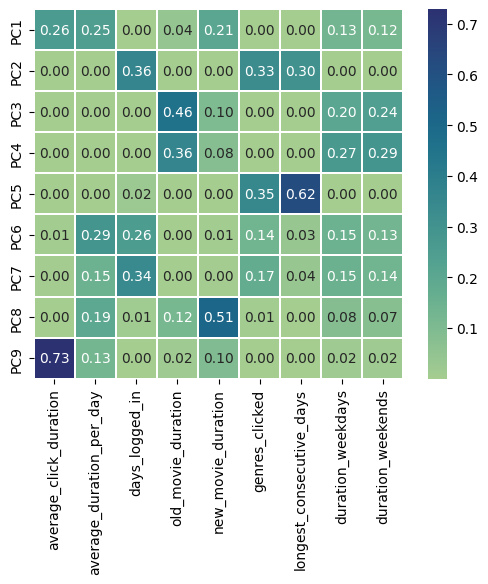

In [ ]:
n = len(X.axes[1]) # number of columns of X
pca = PCA(n_components = n).fit(X) 
sns.heatmap(pca.components_**2,
                 yticklabels=["PC"+str(x) for x in range(1, pca.n_components_+1)],
                 xticklabels=to_norm,
                 annot=True,
                 fmt='.2f',
                 square=True,
                 linewidths=0.1,
                 cmap= "crest")

#### 2.3.1 & 2.3.4
Using the features `['0', '1', '2']` and setting the number of clusters to `4` we get the following clustering by performing `our_k_means_standard` or `our_k_means_adv()` (i.e. k-means++), respectively.

For the exact implementations we refer to the `functions.py`-file.


Concerning "map-reduce":
-   The so-called "map" is done by `functions.get_new_clusters()`.
-   The so-called "reduce" is done by `functions.calculate_new_centers()`.

By scarcity of computation power we needed to restrict ourselves to the first 1000 entries when performing our k-means-algorithms. A more sophisticated approach of using map-reduce you will find at the end of this section.


In [ ]:
import functions
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

<Axes: xlabel='2', ylabel='1'>

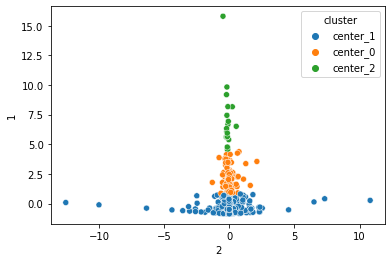

In [ ]:
data = functions.get_data_from_2_2(1000)
data_clustered_adv = functions.our_k_means_adv(3, data, ['0', '1', '2'], max_iterations=10) # i.e. k_means_++
sns.scatterplot(data=data_clustered_adv, x='2', y='1', hue='cluster')    

<Axes: xlabel='2', ylabel='1'>

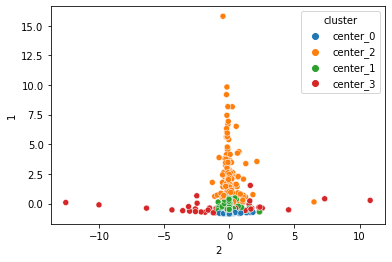

In [ ]:
data_clustered_standard = functions.our_k_means_standard(4, data, ['0', '1', '2'], max_iterations=2) 
sns.scatterplot(data=data_clustered_standard, x='2', y='1', hue='cluster')

#### k-means using map-reduce:

##### initialization phase

1.  Split the data into chunks of 10 000 entries
2.  Choose a random number within 0, 1, ... len(data)-1 
3.  Access the datapoint in this row/ at this index.
 
4. If not all (i.e. k) centers were chosen by now. Consider the chunks (map) from above again. 
5.  Compute the distances to the closest center (data-processing)
6.  sum up the distances for each chunk and each center. (reduce)
7.  Choose a chunk based by random based on a probability proportional to the summed distances of each chunk
8.  After choosing a chunk apply the same to choose a datapoint within the chunk using the distances from 2.
9.  Return to 4

##### clustering phase

Let the first centers be given.

**map** (splitting by center seems irrelevant for map-reduce, more complicated than necessary)
1.  distances to centers can be computed parallely (each center on one processor). Before we compute the distances to each center we can split the data in arbitrary chunks.
        a) 1st processor computes distances to center 1 for 1st 10 000 entries.
        b) 2nd ... for entry 10 001 to 20 000
2.  By combining our distance-values for each center (the data stays splitted in 10 000 entries for each chunk) we can compute the nearest center for each entry and assign the center to the entry to update the clusters.
3.  Knowing the new centers, we can split the already chunked data again w.r.t their newly assigned centers.

**reduce**
1. within the chunks we can sum up the values of each entry for each cluster and output it together with number of summands 
2. after done so we can combine the chunks and again sum up the values of each entry for each cluster and output it together with number of summands

**putting things together**
1.  given these information we can compute the new centers by sum/(number of summands) for each cluster
2.  Restart the process if not already converged enough.


#### 2.3.2

The two most common methods for choosing the number of clusters in a clustering problem are : The elbow method and the silhouette score method. There are others but these are the most commonly used ones (and they have the advantage of being easier to implement and more easily interpretable). Due to the nature of our code, we'll implement the whole elbow method from scratch.

[0    293.274655
dtype: float64, 0    293.274655
dtype: float64, 0    214.500003
dtype: float64, 0    67.968523
dtype: float64, 0    43.025467
dtype: float64, 0    49.577078
dtype: float64, 0    59.276178
dtype: float64, 0    63.250799
dtype: float64]


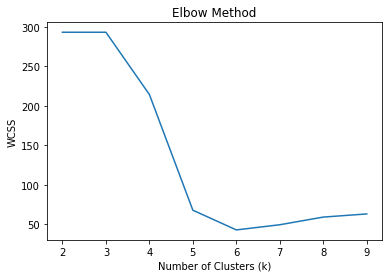

In [ ]:
def elbow_method(k_range, n_iter):
    """
    This takes the range of cluster values we want to experiment with and plot
    the WCSS (total sum of squares for points relative to their center in each cluster)
    The elbow method consists of choosing the number of cluster where the curve
    shows an "elbow".
    """
    wcss_values = []
    # We unpack the value of the interval we chose ((2,10) for our example) for our loop
    for n_clusters in range(*k_range):
        data_clustered_standard_elb = functions.our_k_means_standard(n_clusters, data, ['0', '1', '2'], max_iterations=n_iter)
        wcss = functions.compute_wcss(n_clusters, data_clustered_standard_elb, ['0', '1', '2'])
        wcss_values.append(wcss)
        
    print(wcss_values)
    plt.plot(range(*k_range), wcss_values)
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

elbow_method((2,10), 7)

When we look at the curve, we can see that for $k = 3$, the curve shows an elbow. Hence, when strictly looking at this, we could say that $k_{opt} = 3$. However, we have to consider that due to computational issues, we can't (yet) do this for the whole dataset for a large number of iterations, we can't be 100% sure of this result then.

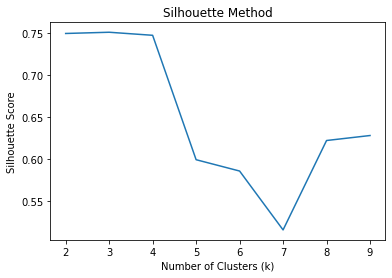

In [ ]:
def silhouette_method(data, essential_cols, k_range, n_iter):
    """
    This function computes the silhouette score for the k-means++ implementation for every value of k we
    choose in an interval, this then plots out the curve of each silhouette score.
    """
    silhouette_avg_scores = []
    for n_clusters in range(*k_range):
        data_clustered_standard_sil = functions.our_k_means_adv(n_clusters, data, ['0', '1', '2'], max_iterations=n_iter)
        score = silhouette_score(data[essential_cols], data_clustered_standard_sil['cluster'])
        silhouette_avg_scores.append(score)
    
    plt.plot(range(*k_range), silhouette_avg_scores)
    plt.title('Silhouette Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()
    
silhouette_method(data, ['0', '1', '2'], (2,10), 10)

Using this method, we could say that 3 seems to be an optimal number of clusters, however, we can see that 5 has also a good average silhouette score and that it presented a slight elbow using the elbow method. As 3 is quite low and may not be suitable for a complex problem like this, one should also consider using larger values.

#### 2.3.5

In this question, I asked ChatGPT to provide me with another clustering algorithm. It wanted to implement DBSCAN first but I kept this implementation for the bonus question. On the second try, the LLM provided me with an implementation of a hierarchical clustering algorithm. This type of clustering algorithm is especially useful to get information on the structure of the data.
The LLM used the Agglomerative clustering algorithm specifically.

<Axes: xlabel='2', ylabel='1'>

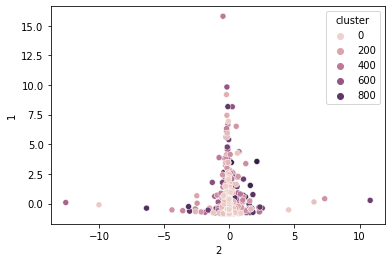

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the data
data = functions.get_data_from_2_2(1000)

# Using Agglomerative Clustering and initially fitting the model without specifying the number of clusters
ac = AgglomerativeClustering(metric='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
clusters = ac.fit_predict(data)
data['cluster'] = clusters

sns.scatterplot(data, x='2', y='1', hue='cluster')

The main difference between this and the K-means is that we don't provide the number of clusters, the algorithm figures it out automatically (the algorithm also seems to output a probability of a point being inside a cluster with the hue). However, because of that, there are a lot more parameters to give. I didn't change the parameters ChatGPT gave me and this gave me this result with 5 different cluster colors (which seems to be consistent with what we had earlier, 5 was also a good choice). I think K-Means is a little bit limited in this day and age and the kind of algorithm I used here can have other uses.

#### 2.4.1

I think the most important variable are related to watch time, so I choose average_click_duration and average_duration_per_day. These variable are somewhat correlated but we only examine them indepently here.

#### 2.4.2

Creating categories is easy for categorical values but much harder for numerical values. To be meaningful, categories must capture an approximately equal part of the data (so we can't just divide the max number of one column into 4 equal pieces). 

In [ ]:
data_orig = pd.read_csv("user.csv")
_, categories = pd.qcut(data_orig['average_click_duration'], [0.25,0.5,0.75,1], labels=False, retbins = True)
print("The bin edges of the data for the column average_click_duration are :", *categories)

The bin edges of the data for the column average_click_duration are : 0.0 3432.4 27341.7 11471935.0


What we can see also is that the 25th percentile (0) is equal to the minimum value of the dataset. We can then choose the first category as "average_click_duration = 0" and the other as the remaining intervals.

We do the same thing with our other variable (average_duration_per_day)

In [ ]:
data_orig = pd.read_csv("user.csv")
_, categories = pd.qcut(data_orig['average_duration_per_day'], [0.25,0.5,0.75,1], labels=False, retbins = True)
print("The bin edges of the data for the column average_duration_per_day are :", *categories)

The bin edges of the data for the column average_duration_per_day are : 0.0 5400.0 41902.225000000006 14007524.0


#### 2.4.3

Now that we have the categories, we can create the pivot tables. We choose 3 as the optimal number of clusters, as was previously mentioned.

In [ ]:

# To ease our work later, we put the cluster values into the original dataframe
data_orig['cluster'] = data_clustered_adv['cluster']

# Bin edges 
bin_edges = [0.0, 0.00001, 3432.4, 27341.7, 11471935.0]

# Categorizing data into bins (we need it for the pivot table)
data_orig['click_duration_category'] = pd.cut(data_orig['average_click_duration'], bins=bin_edges, include_lowest=True, labels=['0', '0-3432.4', '3432.4-27341.7', '27341.7-11471935'])

# Creating a pivot table
pivot_table = pd.pivot_table(data_orig, values='average_click_duration', index='cluster', columns='click_duration_category', aggfunc='count')
print(pivot_table)

click_duration_category    0  0-3432.4  3432.4-27341.7  27341.7-11471935
cluster                                                                 
center_0                   2        23              64                60
center_1                 277       189             166               199
center_2                   0         4              15                 1


In [ ]:
# We do the same thing as earlier with the other variable (average_duration_per_day), the bin edges are not the same
bin_edges_day_duration = [0.0, 0.00001, 5400.0, 41902.225000000006, 14007524.0]

data_orig['average_duration_category'] = pd.cut(data_orig['average_duration_per_day'], bins=bin_edges_day_duration, include_lowest=True, labels=['0', '0-3432.4', '3432.4-27341.7', '27341.7-11471935'])

pivot_table_day_duration = pd.pivot_table(data_orig, values='average_duration_per_day', index='cluster', columns='average_duration_category', aggfunc='count')
print(pivot_table_day_duration)

average_duration_category    0  0-3432.4  3432.4-27341.7  27341.7-11471935
cluster                                                                   
center_0                     2        23              58                66
center_1                   277       186             176               192
center_2                     0         1              15                 4


#### 2.4.4



In [ ]:
# We compute the pivot table with all the percentages for each row as values.
pivot_percentage_clicks = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
pivot_percentage_day = pivot_table_day_duration.div(pivot_table_day_duration.sum(axis=1),  axis=0) * 100

print(pivot_percentage_clicks)
print(pivot_percentage_day)

click_duration_category          0   0-3432.4  3432.4-27341.7  \
cluster                                                         
center_0                  1.342282  15.436242       42.953020   
center_1                 33.333333  22.743682       19.975933   
center_2                  0.000000  20.000000       75.000000   

click_duration_category  27341.7-11471935  
cluster                                    
center_0                        40.268456  
center_1                        23.947052  
center_2                         5.000000  
average_duration_category          0   0-3432.4  3432.4-27341.7  \
cluster                                                           
center_0                    1.342282  15.436242       38.926174   
center_1                   33.333333  22.382671       21.179302   
center_2                    0.000000   5.000000       75.000000   

average_duration_category  27341.7-11471935  
cluster                                      
center_0                  

#### 2.4.5

What we have to say first is that cluster_2 here for example has much less value than cluster_0, this may be fine with the data we have (it doesn't necessarily equate to overfitting/underfitting) but with 3 dimensions like this, it's hard to say if the values we have are correct (and just comparing it to the python implementation of the algorithms is tricky as two different entirely clustering results can be "good" depending on the data).

However, from the percentage pivot table, we can easily see that the two variable present some similarities. We can also see that cluster_0 has very high values for both variables while cluster_1 has a bigger amount of 0s (higher than the total amount in the dataset which is close to 25%). Once again, it's hard to interpret center_2 but we can see that it has the highest proportion of high values, this may be a type of people who have a certain type of movie consumption.

#### 2.4.6

There are a number of metrics used to evaluate a clustering model. They can be based on labels or not (like here).
Here I use 2 that have different interpretations.


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

essential_cols = ['0', '1', '2']
silhouette_avg = silhouette_score(data[essential_cols], data_clustered_adv['cluster'])
davies_bouldin = davies_bouldin_score(data[essential_cols], data_clustered_adv['cluster'])

print(silhouette_avg)
print(davies_bouldin)

0.5966456709193908
0.9909035625133744


The two results can be interpreted differently. The silhouette score spans from -1 to 1, a silhouette score of 1 means that all objects are perfectly similar to other objects in their cluster and entirely different from other objects in other clusters. A score of 0.6 like here is considered pretty good because it means that the clusters separate the inputs well. However, depending on the problem, this could also be a sign of overfitting (if the silhouette score is too high).

The other metric is the davies boulding score, it ranges from 0 to infinity. A low davies bouldin is considered good (but it depends on the range of the values of the input) and indicates good separation.

Once again, as these metrics are unsupervised only, their interpretation remains complicated and may necessitate expert knowledge on the subject matter to get deeper into the analysis.

## 3. BONUS

Once I asked ChatGPT for this kind of algorithm, he gave me the name of DBSCAN, one of its implementation is available from sklearn. 
What you have to keep in mind is that we don't input the number of clusters we want as parameters, instead we ajust the eps and min_samples values depending on the dataset to find a result with the number of clusters found automatically. From what I gathered online, the eps value can be obtained through the elbow method and empirical evidence shows that min_samples can be choses as dimension + 1 if the dimension value is low.

0        0
1        0
2        0
3        0
4        0
        ..
14995    1
14996    1
14997    1
14998    1
14999    1
Name: cluster, Length: 15000, dtype: int64


<Axes: xlabel='2', ylabel='1'>

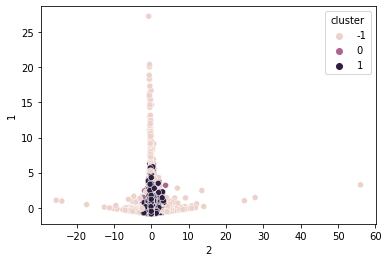

In [ ]:
from sklearn.cluster import DBSCAN
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# The implementation in sklearn is very optimised so we can choose a large amount of inputs.
data = functions.get_data_from_2_2(15000)

dbscan = DBSCAN(eps=5, min_samples=4)
clusters = dbscan.fit_predict(data)

data['cluster'] = clusters

sns.scatterplot(data, x='2', y='1', hue='cluster')


If we plot the same plot as before, we can see that the algorithm chooses 3 as the optimal number of clusters automatically, this seems to be in line with what we had before. Keep in mind that this depends on the choice of the hyperparameters of the model so this may not be the "optimal" number of parameters in the sense if kmeans (but it will be for every choice of hypermater which represent a different interpretation of the data)

## 4. Command Line Question (CLQ)

## 5. Algorithmic Question
### a)  
*Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.*

It is nice that the helped help the helpables. Nevertheless we prefer a direct solution instead of a recursive one.
Let n be the number of exam_scores. 
1. We multiply the n//2 lowest exam-scores by -1.
2. We sum up the modified exam-scores.
3. If n is odd we also add the initial score to the sum.
This sum yields the highest possible score (proof follows after the code).

Equivalently to 1. and 2. we can also addup all scores and then substract two times the sum of the n//2 lowest scores, which is done below.
To find the n//2 lowest exam scores we use the method heapq.nsmallest, which is based on the heap-property.

In [ ]:
from heapq import nsmallest

In [ ]:
def getMaxResult(initial_score, exam_scores):
    n = len(exam_scores)
    negative_scores = nsmallest(n//2, exam_scores)
    res = sum(exam_scores) - 2*sum(negative_scores)
    if n % 2 == 0 :
        res += initial_score
    return res

We deliver the solutions to the three samples:

In [ ]:
sample_set = [ [8, [5,7,1] ] , [25, [18, 24, 21, 32, 27]], [30, [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79] ] ]
for sample in sample_set:
    print("initial_score:", sample[0])
    print("exam_scores:", sample[1])    
    print("maximal_score:", getMaxResult(sample[0], sample[1]))
    print()

initial_score: 8
exam_scores: [5, 7, 1]
maximal_score: 11

initial_score: 25
exam_scores: [18, 24, 21, 32, 27]
maximal_score: 44

initial_score: 30
exam_scores: [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
maximal_score: 205



Next we adapt the code to a program based on user-input.

In [ ]:
initial_score = int(input())
exam_scores = list(map(int,input().split(' ')))
getMaxResult(initial_score, exam_scores) # ran with sample input 8, [5, 7, 1]

11

Moving on to the proof, yielding the correctness of the code above.

<img src="data/ADM_HW4_AQ_proof.jpg" alt="Alternative text" />

### b) 
*Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!*

Summation of 1.5*n values takes O(n). Hence the only problematic step is computing the n//2-lowest values. To determine these we can first create a min-heap. Then we can pop() the minimal value. In the worst case the underlying min-heap does not decrease in height. Hence we have a time-complexity of O(n//2 * log(n//2)), i.e. O(n * log(n)).

Is it possible to decrease this time further?
Computing the n//2-lowest values is equivalent to computing the median and then partitioning the array into the bigger and lower half. Given the median we could partition the array in O(n). But unfortunately does the exact computation of the median take also O(nlog(n)). Hence we pleade for optimality of our algorithm.

### c) 
*If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)*

Fortunately Frederico is wrong :)

### d) 
*Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!*

**Question:** fastest way (in terms of worst case time-complexity) to get n//2 lowest values of an array.

**ChatGPT-Answer:**
The fastest way to find the n//2 lowest values in an array of length n in terms of worst-case time complexity is to use a selection algorithm such as QuickSelect. QuickSelect is an efficient in-place variant of the QuickSort algorithm that can find the kth smallest element in an unordered list. It is based on the partition process of QuickSort.


**Resumé:**
The worst-case time complexity of QuickSelect is known to be O(n²) caused by bad choices of pivot-elements.
